In [1]:
# Mount "My Drive" into /content/drive
from google.colab import drive
private_dir = "Courses-VinBigdata/Course-Deep-Learning/Project/"
google_drive_dir = "Final_Project_DL"  # @param
#bml-notebooks/
drive.mount('/content/drive')

mount_point = "/content/drive/MyDrive/{}".format(google_drive_dir)

# Change the root directory to your mount_point
%cd '$mount_point'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1BOvFtzoVhfYNe70lBGxYzhPlDElSrazo/Final_Project_DL


# <span style="color: royalblue;">Load Data</span>
Load the image data with labels.

In [2]:
import numpy as np
from src.loadData import loadFer2013
from keras.utils import to_categorical


In [3]:
emotions = {0: 'Angry', 1:'Disgust', 2:'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
class_names = list(emotions.values())
class_names

['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [4]:
X_train,X_val,X_test,y_train,y_val,y_test = loadFer2013('fer2013/icml_face_data.csv')

y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)

In [5]:
X_train.shape

(28623, 48, 48)

#Imbalance Data

In [6]:
import imblearn

if imblearn.__version__.split('.')[1] != '7':
   !pip install -U imbalanced-learn

In [7]:
def SMOTE_data(X_train,y_train,mode='smote'):
    if mode=='random':
        oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='auto')
    else:
        oversample = imblearn.over_sampling.SMOTE()

    X_train = X_train.reshape(X_train.shape[0], -1)

    X_train, y_train = oversample.fit_resample(X_train, y_train)

    X_train = X_train.reshape((X_train.shape[0], 48, 48))

    return X_train, y_train

In [8]:
X_train_smote,y_train_smote= SMOTE_data(X_train,y_train,mode='random')
y_train_onehot = to_categorical(y_train_smote)

#Preprocessing

In [9]:
def preprocessX(X):
    # X = X.astype(np.float32)
    # X = (X - X.mean())/X.std()
    # X = X.astype(np.uint8)
    return np.expand_dims(X,axis=-1)

X_processed_train = preprocessX(X_train_smote)
X_processed_val = preprocessX(X_val)
X_processed_test = preprocessX(X_test)
X_processed_train.shape,X_processed_val.shape,X_processed_test.shape

((50351, 48, 48, 1), (3589, 48, 48, 1), (3589, 48, 48, 1))

#Training

In [10]:
import keras
from keras.preprocessing import image
from keras import applications as keras_applications

In [11]:
!pip install keras_applications
!pip install git+https://github.com/rcmalli/keras-vggface.git

     |████████████████████████████████| 51kB 3.0MB/s 
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-jabjrgya
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-jabjrgya
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8310 sha256=0089f3e55c5e30997245f6a8ef68ca7f36473f60ef2ea94e816b2fe3f1935b53
  Stored in directory: /tmp/pip-ephem-wheel-cache-i5nqzxu6/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [12]:
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

In [13]:
from copy import deepcopy as copy

def smooth_labels(y, smooth_factor):
    '''Convert a matrix of one-hot row-vector labels into smoothed versions.

    # Arguments
        y: matrix of one-hot row-vector labels to be smoothed
        smooth_factor: label smoothing factor (between 0 and 1)

    # Returns
        A matrix of smoothed labels.
    '''
    assert len(y.shape) == 2, 'input should be a batch of one-hot-encoded data'
    y2 = copy(y)
    if 0 <= smooth_factor <= 1:
        # label smoothing ref: https://www.robots.ox.ac.uk/~vgg/rg/papers/reinception.pdf
        y2 *= 1 - smooth_factor
        y2 += smooth_factor / y.shape[1]
    else:
        raise Exception(
            'Invalid label smoothing factor: ' + str(smooth_factor))
    return y2

In [14]:
from keras.utils import Sequence
from keras.utils import to_categorical
import cv2
from math import floor

class data_sequence(Sequence):
    '''
      yield sequence of data
      features -- list of features
      labels -- list of labels
      target_channels {int} -- 1 (gray) or 3(RGB)
    '''
    def __init__(self, features, labels, batch_size=128, target_dim=(224,224), 
                 n_classes=7, shuffle=True, smooth=0.0):
        'Initialization'
        assert len(features)==len(labels), 'number of feature and labels not consistent'
        self.features = features
        self.labels = labels
        self.batch_size = batch_size
        self.target_dim = target_dim
        self.target_channels = 3
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.smooth = smooth
        self.sample_count = len(labels)
        self.indexes = np.arange(self.sample_count)
        self.on_epoch_end()
#         self.verbose = verbose

    def __len__(self):
        'Denotes the number of batches per epoch'
        return floor(self.sample_count / self.batch_size)

    def __gray2RGB__(self,x):
      if len(x.shape)==2:
        return np.stack((x,x,x),-1)
      else:
        assert len(x.shape)==3
        if len(x[0,0,:]) == 1:
          return np.stack((x[:,:,0],x[:,:,0],x[:,:,0]),-1)
        else:
          assert len(x[0,0,:])==self.target_channels
      return x


    def __getitem__(self, idx):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        X = np.empty((self.batch_size, *self.target_dim, self.target_channels))
        Y = np.empty((self.batch_size, self.n_classes))
        for i,ind in enumerate(indexes):
          x = self.features[ind]
          # resize image to the target size 
          x = cv2.resize(x,self.target_dim,interpolation=cv2.INTER_CUBIC)
          # x = cv2.equalizeHist(x)
          # x = x.astype(np.float64)
          x = self.__gray2RGB__(x)
          X[i] = utils.preprocess_input(x, version=2) # or version=2 for VGGFace2 ResNet50  
          y = self.labels[ind]
          if isinstance(y,int):
            Y[i]=to_categorical(y,7)
          else:
            assert len(y)==self.n_classes
            Y[i]=y
        X = np.array(X)
        Y = np.array(Y)
        if self.smooth > 0.0:
          smooth_labels(Y, self.smooth)
        return X,Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

#Model

In [15]:
train_sequence = data_sequence(X_processed_train,y_train_onehot,batch_size=64,target_dim=(224,224),n_classes=7,shuffle=True,smooth=0.07)
val_sequence   = data_sequence(X_processed_val,  y_val_onehot,  batch_size=64,target_dim=(224,224),n_classes=7,shuffle=True,smooth=0.0)
test_sequence  = data_sequence(X_processed_test, y_test_onehot, batch_size=64,target_dim=(224,224),n_classes=7,shuffle=True,smooth=0.0)

In [ ]:
vggface = VGGFace(model='resnet50', include_top=False, input_shape = (224,224,3))
vggface.trainable = False
vggface.summary()

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization

# model = Sequential([vggface,
#                     Flatten(),
#                     Dropout(0.5),
#                     BatchNormalization(),
#                     Dense(128, activation='relu'),
#                     Dropout(0.5),
#                     BatchNormalization(),
#                     Dense(len(emotion_dict), activation='softmax', name = 'classifer')])
model = Sequential([vggface,
                    Flatten(),
                    Dropout(0.25),
                    Dense(2048, activation='relu'),
                    Dropout(0.25),
                    Dense(1024, activation='relu'),
                    Dense(7, activation='softmax', name = 'classifer')])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_resnet50 (Functional (None, 1, 1, 2048)        23561152  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
classifer (Dense)            (None, 7)                

In [ ]:
model.compile(optimizer = keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit_generator(generator = train_sequence,
                           validation_data = val_sequence,
                           epochs = 20)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
786/786 [==============================] - 154s 192ms/step - loss: 1.9076 - accuracy: 0.4971 - val_loss: 1.0861 - val_accuracy: 0.6004
Epoch 2/20
786/786 [==============================] - 150s 191ms/step - loss: 0.8740 - accuracy: 0.6777 - val_loss: 1.0205 - val_accuracy: 0.6242
Epoch 3/20
786/786 [==============================] - 150s 191ms/step - loss: 0.7432 - accuracy: 0.7282 - val_loss: 1.0091 - val_accuracy: 0.6401
Epoch 4/20
786/786 [==============================] - 150s 191ms/step - loss: 0.6504 - accuracy: 0.7645 - val_loss: 1.0222 - val_accuracy: 0.6350
Epoch 5/20
786/786 [==============================] - 150s 191ms/step - loss: 0.5788 - accuracy: 0.7882 - val_loss: 1.0510 - val_accuracy: 0.6429
Epoch 6/20
786/786 [==============================] - 150s 191ms/step - loss: 0.5093 - accuracy: 0.8166 - val_loss: 1.0759 - val_accuracy: 0.6395
Epoch 7/20
786/786 [==============================] - 150s 190ms/step - loss: 0.4599 - accuracy: 0.8371 - val_loss: 1.0718 -

In [ ]:
import matplotlib.pyplot as plt


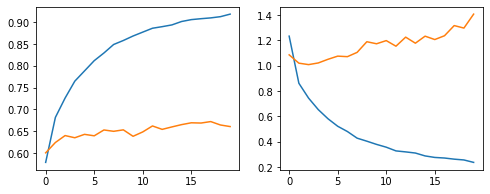

In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

### finetune all layer, lr=1e-4

In [ ]:
for layer in model.layers[0].layers:
    if 'bn' not in layer.name:
        layer.trainable = True

In [ ]:
model.compile(optimizer = keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
hist2 = model.fit_generator(generator = train_sequence,
                            validation_data = val_sequence,
                            epochs = 10)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
786/786 [==============================] - 154s 193ms/step - loss: 0.1837 - accuracy: 0.9377 - val_loss: 1.4324 - val_accuracy: 0.6691
Epoch 2/10
786/786 [==============================] - 151s 192ms/step - loss: 0.1316 - accuracy: 0.9554 - val_loss: 1.4707 - val_accuracy: 0.6713
Epoch 3/10
786/786 [==============================] - 150s 191ms/step - loss: 0.1181 - accuracy: 0.9591 - val_loss: 1.4962 - val_accuracy: 0.6722
Epoch 4/10
786/786 [==============================] - 150s 191ms/step - loss: 0.1165 - accuracy: 0.9599 - val_loss: 1.4983 - val_accuracy: 0.6772
Epoch 5/10
786/786 [==============================] - 150s 191ms/step - loss: 0.1123 - accuracy: 0.9610 - val_loss: 1.5332 - val_accuracy: 0.6758
Epoch 6/10
786/786 [==============================] - 150s 191ms/step - loss: 0.1016 - accuracy: 0.9647 - val_loss: 1.5620 - val_accuracy: 0.6775
Epoch 7/10
786/786 [==============================] - 150s 191ms/step - loss: 0.1073 - accuracy: 0.9616 - val_loss: 1.5723 -

In [ ]:
for key in ['accuracy','val_accuracy','loss','val_loss']:
    hist.history[key] = hist.history[key] + hist2.history[key]

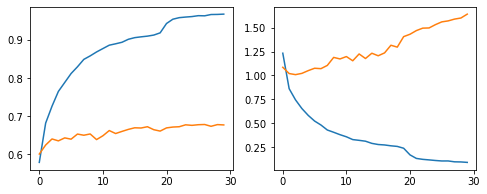

In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

### finetune further all, lr=1e-5

In [ ]:
model = keras.models.load_model('saved_checkpoint/Checkpoint/VGGFACE2_CLEANED.h5')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_resnet50 (Functional (None, 1, 1, 2048)        23561152  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
classifer (Dense)            (None, 7)                

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('saved_checkpoint/Checkpoint/VGGFACE2_CLEANED.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


In [ ]:
model.compile(optimizer = keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
hist3 = model.fit_generator(generator = train_sequence,
                            validation_data = val_sequence,
                            epochs = 20,
                            callbacks=[es,mc])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
786/786 [==============================] - 1049s 1s/step - loss: 0.0776 - accuracy: 0.9735 - val_loss: 1.4132 - val_accuracy: 0.7006

Epoch 00001: val_accuracy improved from -inf to 0.70061, saving model to saved_checkpoint/Checkpoint/VGGFACE2_CLEANED.h5
Epoch 2/20
786/786 [==============================] - 1044s 1s/step - loss: 0.0806 - accuracy: 0.9721 - val_loss: 1.3989 - val_accuracy: 0.7015

Epoch 00002: val_accuracy improved from 0.70061 to 0.70145, saving model to saved_checkpoint/Checkpoint/VGGFACE2_CLEANED.h5
Epoch 3/20
786/786 [==============================] - 1044s 1s/step - loss: 0.0637 - accuracy: 0.9780 - val_loss: 1.3831 - val_accuracy: 0.6953

Epoch 00003: val_accuracy did not improve from 0.70145
Epoch 4/20
786/786 [==============================] - 1045s 1s/step - loss: 0.0618 - accuracy: 0.9780 - val_loss: 1.3847 - val_accuracy: 0.6973

Epoch 00004: val_accuracy did not improve from 0.70145
Epoch 5/20
786/786 [==============================] - 1047s 1s/st

In [ ]:
for key in ['accuracy','val_accuracy','loss','val_loss']:
    hist.history[key] = hist.history[key] + hist3.history[key]

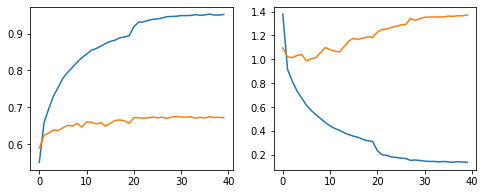

In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

# model test

In [16]:
model = keras.models.load_model('saved_checkpoint/Checkpoint/VGGFACE2_CLEANED.h5')

In [17]:
test_sequence  = data_sequence(X_processed_test, y_test_onehot, batch_size=37,target_dim=(224,224),n_classes=7,shuffle=False,smooth=0.0)

In [19]:
model.evaluate(val_sequence)

56/56 [==============================] - 8s 131ms/step - loss: 1.3638 - accuracy: 0.7031


[1.3637608289718628, 0.703125]

In [18]:
model.evaluate(test_sequence)

97/97 [==============================] - 15s 82ms/step - loss: 1.1866 - accuracy: 0.7183


[1.1865606307983398, 0.7183059453964233]

### Confusion matrix

In [ ]:
import tensorflow as tf
y_pred = []
for x,y in test_sequence:
    y_pred = y_pred + list(np.argmax(model.predict(x), axis=-1))

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,y_pred)

0.7183059348007802

In [ ]:
import pandas as pd

confusion_matrix = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
confusion_matrix = np.around(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis], decimals=2)

confusion_matrix = pd.DataFrame(confusion_matrix,
                                index = class_names, 
                                columns = class_names)

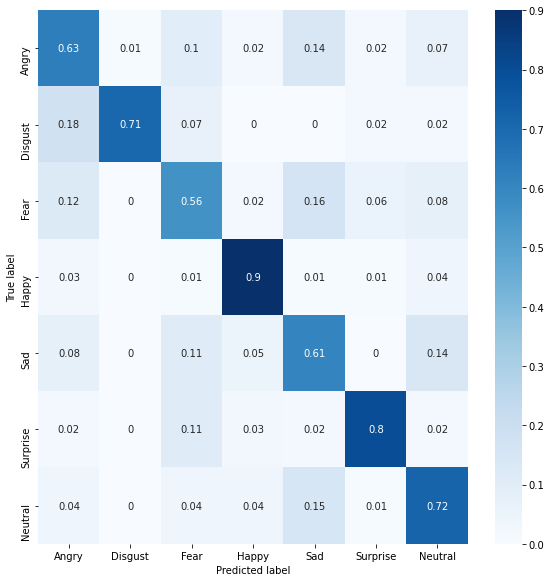

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()